In [1]:
# Import the libraries we will be using
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('lab2_train.csv')
test_data = pd.read_csv('lab2_test.csv')

In [4]:
def get_reconstruct_error(X, U, V, mask):
    return np.linalg.norm((np.nan_to_num(X, nan=-1) - (U @ V)) * mask)

In [136]:
def nmf(X: pd.DataFrame, n_components: int, mask: np.ndarray, max_iter: int = 1000, tol: float = 1e-3) -> tuple:
    # Initialize W and H with random non-negative values
    A = X.values
    U = np.random.rand(X.shape[0], n_components)
    V = np.random.rand(n_components, X.shape[1])
    error = get_reconstruct_error(A, U, V, mask)
    epsilon = 1e-6

    for i in range(max_iter):
        print(f'Iteration {i+1}/{max_iter}', end='\r')
        
        V_old = V
        U_old = U
        U = U_old * (((mask * A) @ V_old.T) / (((mask * (U_old @ V_old)) @ V_old.T) + epsilon))
        V = V_old * ((U_old.T @ (mask * A)) / ((U_old.T @ (mask * (U_old @ V_old))) + epsilon))

        U = U / (U.max() + epsilon)
        V = V / (V.max() + epsilon)

        error_new = get_reconstruct_error(A, U, V, mask)
        if abs(error - error_new) < tol:
            break
        error = error_new

    return U, V

In [137]:
from sklearn.model_selection import train_test_split

In [193]:
train, _ = train_test_split(train_data, test_size=0.2)

In [223]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NMFModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components: int = 2, max_iter: int = 1000, tol: float = 1e-3, threshold: float = 1.0):
        self.classes_ = None
        self.filled = None
        self.pivot = None
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.threshold = threshold

    def fit(self, X, y=None, is_pivot=False):
        if is_pivot:
            self.pivot = X
            self.classes_ = np.unique(self.pivot.values)
        else:
            self.pivot = pd.pivot_table(X, index='user_from_id', columns='user_to_id', values='is_like', fill_value=np.nan)
            self.classes_ = np.unique(X['is_like'].values)
        mask = (~self.pivot.isna()).astype(int)
        u, v = nmf(self.pivot.fillna(0.5), self.n_components, mask, max_iter=self.max_iter, tol=self.tol)
        self.filled = u @ v
        return self

    def predict(self, X):
        predictions = []
        for row in X.values:
            user_from_id, user_to_id, is_like, _ = row
            if user_from_id in self.filled.index and user_to_id in self.filled.columns:
                predictions.append((self.filled.loc[user_from_id, user_to_id] >= self.threshold))
            else:
                predictions.append(np.nan)
        return np.array(predictions)

In [142]:
def get_accuracy(y_true, y_pred):
    total, correct = 0, 0
    for i, is_like in enumerate(y_true.values):
        print(f'Iteration {i+1}/{len(y_true.values)}', end='\r')
        if not np.isnan(y_pred[i]):
            total += 1
            if y_pred[i] == is_like:
                correct += 1
    return correct / total

In [147]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {
    'n_components': [2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'max_iter': [100], 
    'tol': [1e-2],
    'threshold': [0.3, 0.5, 0.7, 1.0]
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_function = make_scorer(get_accuracy)

In [148]:
grid_search = GridSearchCV(NMFModel(), param_grid, cv=kf, scoring=scoring_function, verbose=5)

In [149]:
grid_search.fit(train, train['is_like'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_iter=100, n_components=2, threshold=0.3, tol=0.01;, score=0.841 total time=  25.4s
[CV 2/5] END max_iter=100, n_components=2, threshold=0.3, tol=0.01;, score=0.832 total time=  19.9s
[CV 3/5] END max_iter=100, n_components=2, threshold=0.3, tol=0.01;, score=0.832 total time=  12.2s
[CV 4/5] END max_iter=100, n_components=2, threshold=0.3, tol=0.01;, score=0.841 total time=   2.6s
[CV 5/5] END max_iter=100, n_components=2, threshold=0.3, tol=0.01;, score=0.834 total time=  12.0s
[CV 1/5] END max_iter=100, n_components=2, threshold=0.5, tol=0.01;, score=0.841 total time=  18.0s
[CV 2/5] END max_iter=100, n_components=2, threshold=0.5, tol=0.01;, score=0.832 total time=  15.7s
[CV 3/5] END max_iter=100, n_components=2, threshold=0.5, tol=0.01;, score=0.832 total time=  14.0s
[CV 4/5] END max_iter=100, n_components=2, threshold=0.5, tol=0.01;, score=0.838 total time=  16.3s
[CV 5/5] END max_iter=100, n_component

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=NMFModel(),
             param_grid={'max_iter': [100],
                         'n_components': [2, 5, 10, 20, 50, 100, 200, 500,
                                          1000],
                         'threshold': [0.3, 0.5, 0.7, 1.0], 'tol': [0.01]},
             scoring=make_scorer(get_accuracy), verbose=5)

In [152]:
grid_search.best_score_

0.8370853827587055

In [153]:
grid_search.best_params_

{'max_iter': 100, 'n_components': 1000, 'threshold': 0.3, 'tol': 0.01}

In [154]:
grid_search.cv_results_ 

{'mean_fit_time': array([ 14.27781415,  15.62942472,  13.90310435,  13.86608448,
         17.33090167,  15.85391111,  19.58736854,  17.41595535,
         20.18986163,  22.59092131,  19.67384248,  23.73127565,
         21.99281373,  25.28355227,  26.4555687 ,  29.90601711,
         36.98020344,  33.99049497,  40.48187728,  37.13596735,
         43.66611834,  38.89048233,  46.60797873,  52.15666227,
         72.00972857,  61.32960148,  59.01137161,  67.10519609,
        105.81308322,  87.21099601, 117.51019182, 121.7214448 ,
        158.91225729, 162.51667004, 190.06865926, 178.91935763]),
 'std_fit_time': array([ 7.73735525,  1.27727283,  5.87223352,  5.01639603,  1.96195716,
         3.18484199,  3.65350038,  2.11923401,  2.83082011,  4.6157683 ,
         2.51202071,  4.02831202,  4.29610755,  4.01319544,  2.67686609,
         2.2569897 ,  3.40147385,  7.40894772, 10.21514826,  8.86141629,
        10.22643166, 13.42009957,  8.9192918 ,  3.59287034, 17.57846646,
        18.11492407, 21.

In [205]:
train, test = train_test_split(train_data, test_size=0.2)

In [206]:
pivot = pd.pivot_table(train, index='user_from_id', columns='user_to_id', values='is_like', fill_value=np.nan)

In [207]:
user_from_ids = pivot.index
user_to_ids = pivot.columns

In [208]:
print(len(user_from_ids))
print(len(user_to_ids))

3098
3001


In [214]:
def get_non_nan_distribution(pivot):
    user_from_ids = pivot.index
    user_to_ids = pivot.columns
    non_nan_rows_count = {}
    for user_from_id in user_from_ids:
        non_nan_rows_count[user_from_id] = pivot.loc[user_from_id].count()
    non_nan_cols_count = {}
    for user_to_id in user_to_ids:
        non_nan_cols_count[user_to_id] = pivot[user_to_id].count()
    plt.hist(non_nan_rows_count.values(), bins=100)
    plt.show()
    plt.hist(non_nan_cols_count.values(), bins=100)
    plt.show()
    return non_nan_rows_count, non_nan_cols_count

In [215]:
train_removed = pivot.copy()

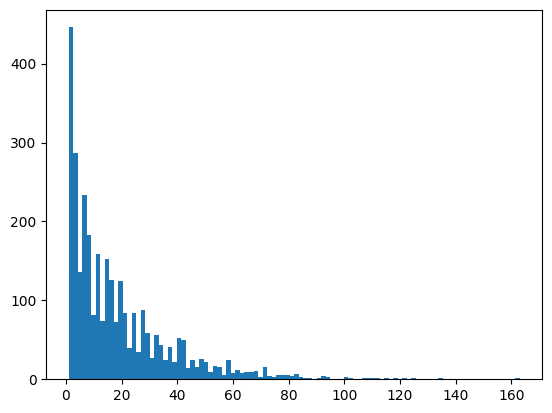

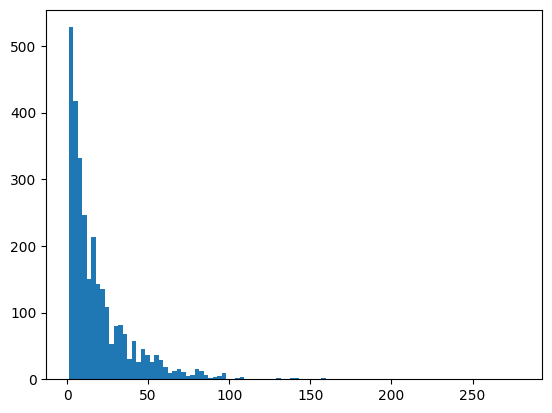

In [216]:
non_nan_rows_count, non_nan_cols_count = get_non_nan_distribution(pivot)

In [217]:
for i, user_from_id in enumerate(user_from_ids):
    print(f'Iteration {i+1}/{len(user_from_ids)}', end='\r')
    if non_nan_rows_count[user_from_id] < 10:
        train_removed = train_removed.drop(user_from_id, axis=0)

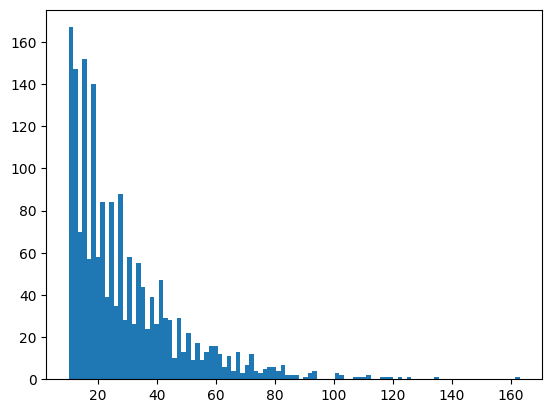

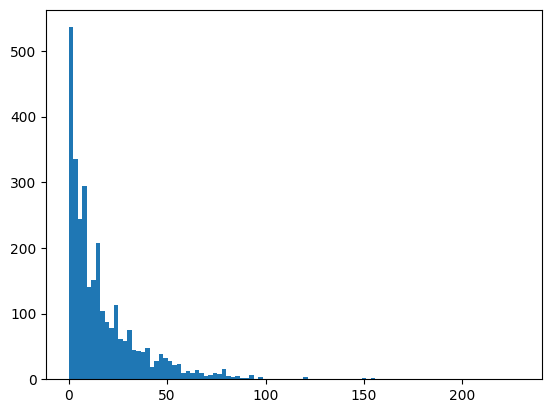

({1: 20,
  14: 14,
  15: 54,
  16: 35,
  17: 16,
  18: 43,
  19: 41,
  20: 93,
  21: 37,
  22: 11,
  23: 22,
  24: 56,
  25: 118,
  26: 78,
  27: 60,
  28: 58,
  29: 13,
  30: 134,
  31: 57,
  32: 58,
  33: 44,
  34: 23,
  35: 44,
  36: 72,
  37: 23,
  38: 94,
  39: 34,
  40: 125,
  41: 66,
  42: 17,
  43: 42,
  44: 72,
  45: 16,
  46: 43,
  47: 40,
  48: 81,
  49: 75,
  51: 163,
  52: 55,
  53: 79,
  54: 32,
  55: 37,
  56: 62,
  57: 36,
  58: 43,
  59: 84,
  60: 29,
  61: 72,
  62: 40,
  63: 58,
  64: 75,
  65: 54,
  66: 59,
  68: 18,
  69: 51,
  70: 35,
  71: 39,
  72: 54,
  73: 88,
  74: 17,
  75: 47,
  76: 10,
  77: 20,
  78: 44,
  79: 68,
  80: 69,
  81: 49,
  82: 14,
  83: 71,
  84: 32,
  85: 36,
  86: 61,
  87: 19,
  88: 59,
  89: 29,
  90: 35,
  91: 44,
  92: 31,
  93: 65,
  94: 30,
  95: 42,
  96: 46,
  97: 60,
  98: 61,
  99: 30,
  100: 56,
  101: 86,
  102: 19,
  103: 53,
  104: 108,
  105: 18,
  106: 19,
  107: 28,
  108: 13,
  109: 17,
  110: 68,
  111: 43,
  112: 24,
  1

In [218]:
get_non_nan_distribution(train_removed)

In [219]:
for i, user_to_id in enumerate(user_to_ids):
    print(f'Iteration {i+1}/{len(user_to_ids)}', end='\r')
    if non_nan_cols_count[user_to_id] < 10:
        train_removed = train_removed.drop(user_to_id, axis=1)

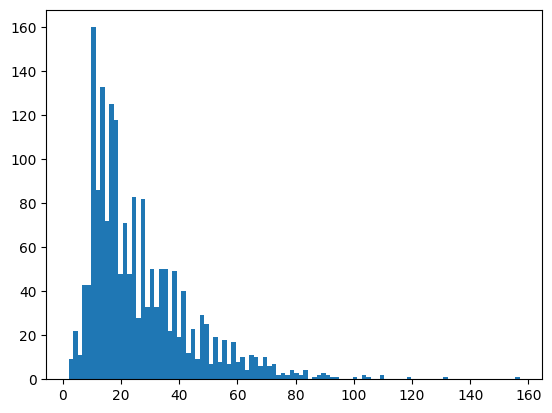

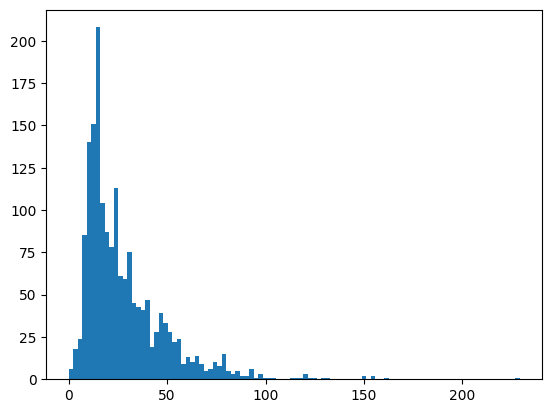

({1: 8,
  14: 13,
  15: 50,
  16: 32,
  17: 16,
  18: 42,
  19: 39,
  20: 91,
  21: 36,
  22: 11,
  23: 22,
  24: 56,
  25: 109,
  26: 77,
  27: 59,
  28: 54,
  29: 13,
  30: 132,
  31: 55,
  32: 57,
  33: 43,
  34: 22,
  35: 44,
  36: 70,
  37: 22,
  38: 88,
  39: 33,
  40: 119,
  41: 64,
  42: 17,
  43: 40,
  44: 70,
  45: 16,
  46: 42,
  47: 40,
  48: 78,
  49: 70,
  51: 157,
  52: 53,
  53: 78,
  54: 32,
  55: 37,
  56: 61,
  57: 36,
  58: 41,
  59: 77,
  60: 27,
  61: 68,
  62: 39,
  63: 57,
  64: 71,
  65: 54,
  66: 55,
  68: 15,
  69: 51,
  70: 34,
  71: 39,
  72: 49,
  73: 79,
  74: 16,
  75: 45,
  76: 9,
  77: 20,
  78: 40,
  79: 65,
  80: 60,
  81: 47,
  82: 14,
  83: 67,
  84: 32,
  85: 36,
  86: 57,
  87: 19,
  88: 58,
  89: 29,
  90: 35,
  91: 43,
  92: 31,
  93: 63,
  94: 29,
  95: 39,
  96: 44,
  97: 59,
  98: 60,
  99: 29,
  100: 56,
  101: 84,
  102: 19,
  103: 51,
  104: 103,
  105: 18,
  106: 19,
  107: 28,
  108: 12,
  109: 17,
  110: 65,
  111: 42,
  112: 17,
  113

In [220]:
get_non_nan_distribution(train_removed)

In [224]:
model = NMFModel(n_components=100, max_iter=100, tol=1e-2, threshold=0.5)
model.fit(train_removed, is_pivot=True)

NMFModel(max_iter=100, n_components=100, threshold=0.5, tol=0.01)

In [225]:
predictions = model.predict(test)
accuracy = get_accuracy(test['is_like'], predictions)

In [226]:
print(accuracy)

0.8327107357479292


In [227]:
train, test = train_test_split(train_data, test_size=0.2)

In [228]:
pivot = pd.pivot_table(train, index='user_from_id', columns='user_to_id', values='is_like', fill_value=np.nan)

In [229]:
user_from_ids = pivot.index
user_to_ids = pivot.columns

In [230]:
user_likes_cnt = {}
for user_from_id in user_from_ids:
    user_likes_cnt[user_from_id] = pivot.loc[user_from_id].sum()
user_liked_cnt = {}
for user_to_id in user_to_ids:
    user_liked_cnt[user_to_id] = pivot[user_to_id].sum()

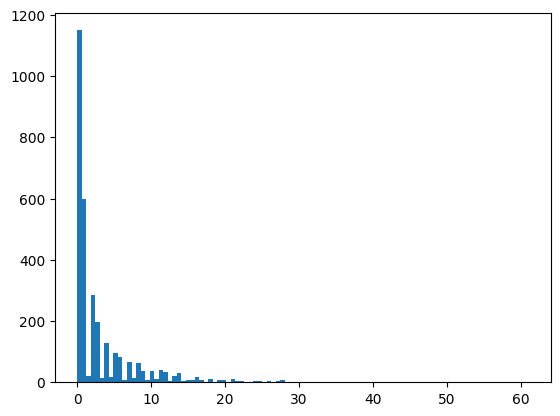

In [234]:
plt.hist(user_likes_cnt.values(), bins=100)
plt.show()

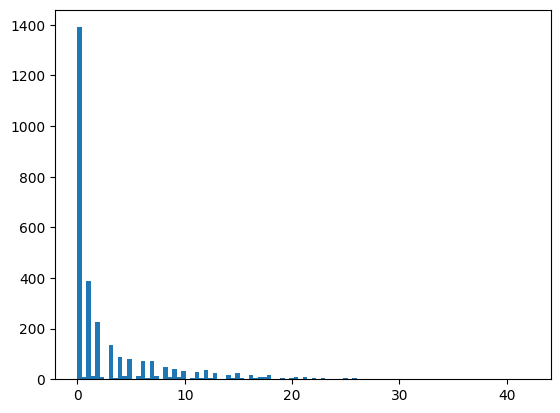

In [233]:
plt.hist(user_liked_cnt.values(), bins=100)
plt.show()

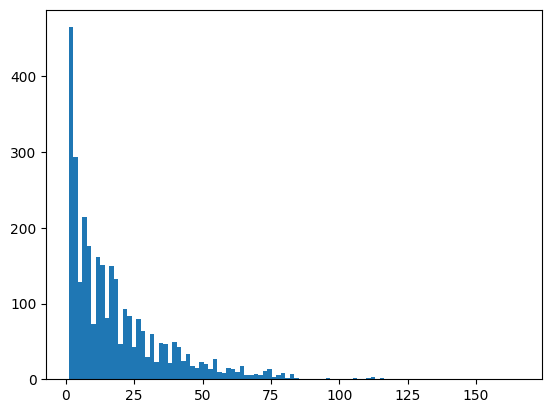

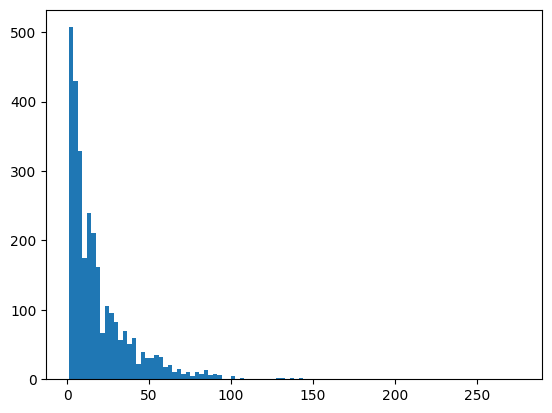

In [235]:
non_nan_rows_count, non_nan_cols_count = get_non_nan_distribution(pivot)

In [236]:
for row in test.values:
    user_from_id, user_to_id, is_like, _ = row
    if user_from_id in pivot.index and user_to_id in pivot.columns:
        print(is_like, user_likes_cnt[user_from_id], user_liked_cnt[user_to_id], non_nan_rows_count[user_from_id], non_nan_cols_count[user_to_id])

False 0.0 0.0 6 9
False 4.0 7.5 46 30
False 5.0 33.5 19 142
False 20.0 4.0 69 17
False 1.0 0.0 22 37
False 1.0 14.5 38 31
True 12.0 8.0 12 70
False 0.0 1.0 50 48
False 0.0 4.5 31 101
False 2.0 20.5 42 60
False 0.5 6.0 137 45
True 1.0 21.0 13 89
False 3.0 0.0 29 90
False 3.0 3.0 75 56
False 6.5 6.0 80 13
False 4.0 35.0 24 129
False 1.0 0.0 32 9
False 7.0 12.5 106 85
False 1.0 8.0 13 24
False 8.0 6.0 52 73
True 11.5 2.0 16 14
False 4.0 36.0 7 180
False 2.0 33.0 96 65
False 1.5 2.0 68 48
True 1.0 18.5 7 63
False 14.0 9.0 52 41
False 0.0 2.0 15 27
False 7.5 10.0 13 49
True 32.0 11.5 36 55
False 4.0 3.0 75 15
False 2.0 7.5 23 38
False 1.0 14.5 110 59
True 3.0 2.0 25 14
False 1.0 10.0 29 162
False 1.0 0.0 48 76
False 4.0 0.0 72 3
False 0.0 0.0 4 30
False 3.0 6.5 46 17
True 5.0 2.0 21 13
True 1.0 3.0 2 17
False 0.0 0.0 39 2
True 16.0 17.5 21 52
False 10.0 18.0 126 27
True 4.0 6.0 11 116
True 30.0 3.0 37 6
True 8.0 5.0 14 10
False 1.0 7.5 3 17
False 0.0 9.0 21 57
True 14.0 11.0 17 51
False 2.5